# Analysis of Fredrika

### Preamble
Imports and constants

In [1]:
from py_fish.operation import (
    speed_profile_from_data,
    total_consumption_from_profile,
    consumption_profile_from_data,
    extract_transit_speed,
    distance_from_profile,
    custom_speed_profile,
)
from py_fish.plotting import (
    plot_speed_profile,
    plot_consumption_data,
    plot_profiles,
    plot_power_data,
)
from py_fish.engine import (
    calculate_consumption,
    EngineApplication,
    calculate_power_from_consumption,
)
from py_fish.loads import (
    calculate_propulsion_power,
    calculate_dc_energy,
    calculate_hydraulics_energy,
)
from py_fish.data import load_all_days, extract_low_acceleration, load_one_day


from py_fish.utils import components_to_profile
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d
from scipy import stats
from pathlib import Path
import os
import folium
import polars as pl

plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 12})

In [2]:
ENGINE_RATING = 242.0
LENGTH = 11.91
BEAM = 4.0
DATE = "2023-11-07"
MOTOR_EFFICIENCY = 0.96
BATTERY_EFFICIENCY = 0.96
VESSEL = "fredrika"

Dates 2023-10-24 and 2023-10-30 gives significantly less predicted consumption.
Both have significant acceleration time.

### Speed profile
Plot of speed profile for specified date

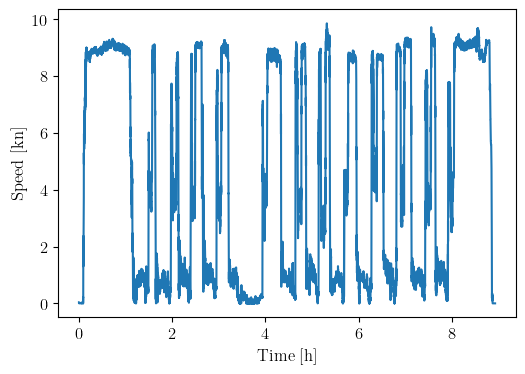

In [3]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_speed_profile(speed_profile_from_data(vessel=VESSEL, date=DATE), ax=ax)

### All consumption data compared with Kemp model

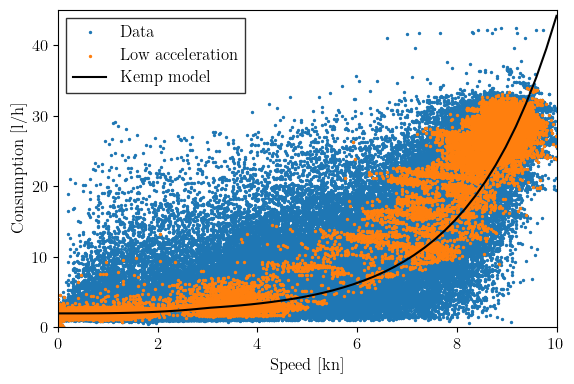

In [4]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
df = load_all_days(vessel=VESSEL)
speeds = np.linspace(0, 10)

speed_and_consumption = df.select(["speed", "consumption"]).to_numpy()
low_acceleration_speed_and_consumption = extract_low_acceleration(speed_and_consumption)

propulsion_powers_kemp = calculate_propulsion_power(
    speeds=speeds, length=LENGTH, beam=BEAM
)
propulsion_consumptions_kemp = calculate_consumption(
    powers=propulsion_powers_kemp,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION,
)

plot_consumption_data(speed_and_consumption, ax, label="Data")
plot_consumption_data(
    low_acceleration_speed_and_consumption, ax, label="Low acceleration"
)
ax.plot(
    speeds,
    propulsion_consumptions_kemp,
    label="Kemp model",
    color="black",
    linestyle="-",
)

ax.set_ylim([0, 45])
ax.set_yticks([0, 10, 20, 30, 40])
lgd = ax.legend(loc=2)

lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_linewidth(1.0)
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/cons_speed_model.png",
    dpi=300,
)

Failed to find a Ghostscript installation.  Distillation step skipped.


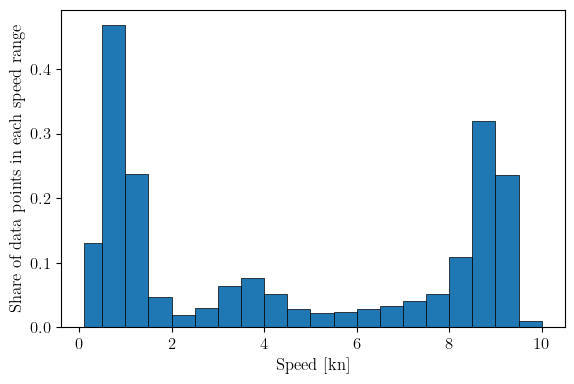

In [5]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
ax.hist(
    speed_and_consumption[:, 0],
    density=True,
    bins=[
        0.1,
        0.5,
        1,
        1.5,
        2,
        2.5,
        3,
        3.5,
        4,
        4.5,
        5,
        5.5,
        6,
        6.5,
        7,
        7.5,
        8,
        8.5,
        9,
        9.5,
        10,
    ],
    linewidth=0.5,
    edgecolor="black",
)
ax.set_xlabel("Speed [kn]")
ax.set_ylabel("Share of data points in each speed range")
fig.tight_layout()
fig.savefig("figures/histogram.eps", format="eps")

### Fit power models
Assumes engine consumption model by Kemp to be accurate, fits load model to the data

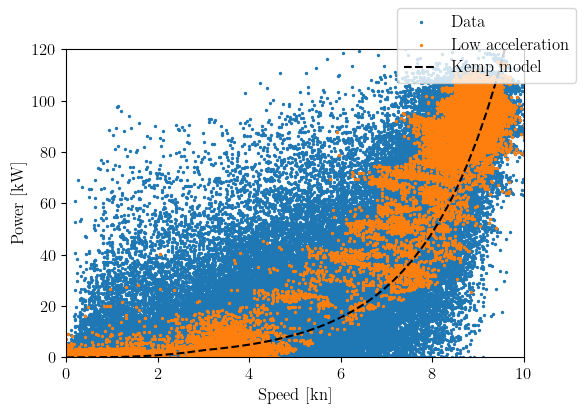

In [6]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
speed_and_power = components_to_profile(
    speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)
low_acceleration_speed_and_power = components_to_profile(
    low_acceleration_speed_and_consumption[:, 0],
    calculate_power_from_consumption(
        consumptions=low_acceleration_speed_and_consumption[:, 1],
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds, propulsion_powers_kemp, label="Kemp model", color="black", linestyle="--"
)
fig.legend()

Fits the constant parameter of the kemp model, i.e. not changeing the exponent

Power increawse with fit: 11.08%
7.984205737376403 6.722207290080549
0.15005532338906505 0.1273992010762607


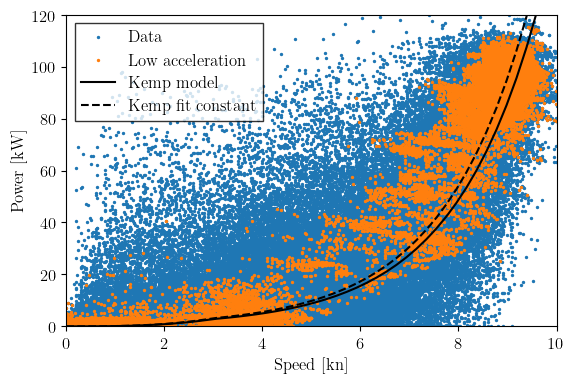

In [7]:
def power_function(speed: float, c4: float) -> float:
    return calculate_propulsion_power(
        speeds=np.ones((1, 1), dtype=float) * speed, length=LENGTH, beam=BEAM, c4=c4
    )[0]


popt, pcov = curve_fit(
    power_function,
    low_acceleration_speed_and_power[:, 0],
    low_acceleration_speed_and_power[:, 1],
)
propulsion_powers_kemp_fit = calculate_propulsion_power(
    speeds=speeds, length=LENGTH, beam=BEAM, c4=popt[0]
)

fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_power_data(speed_and_power, ax, label="Data")
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(speeds, propulsion_powers_kemp, label="Kemp model", color="black")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit constant",
    color="black",
    linestyle="--",
)
lgd = ax.legend(loc=2)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_linewidth(1.0)
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/power_speed_model.png",
    dpi=300,
)
power_increase = popt[0] / 3.6e-3
print(f"Power increawse with fit: {(power_increase-1)*100.0:.2f}%")
rmse = np.sqrt(
    np.sum(
        (
            low_acceleration_speed_and_power[:, 1]
            - calculate_propulsion_power(
                speeds=low_acceleration_speed_and_power[:, 0],
                length=LENGTH,
                beam=BEAM,
            )
        )
        ** 2
    )
    / len(low_acceleration_speed_and_power[:, 0])
)
rmse_fit = np.sqrt(
    np.sum(
        (
            low_acceleration_speed_and_power[:, 1]
            - calculate_propulsion_power(
                speeds=low_acceleration_speed_and_power[:, 0],
                length=LENGTH,
                beam=BEAM,
                c4=popt[0],
            )
        )
        ** 2
    )
    / len(low_acceleration_speed_and_power[:, 0])
)
print(rmse, rmse_fit)
rmse = np.sqrt(
    np.sum(
        (
            low_acceleration_speed_and_power[
                low_acceleration_speed_and_power[:, 0] > 8.5, 1
            ]
            - calculate_propulsion_power(
                speeds=low_acceleration_speed_and_power[
                    low_acceleration_speed_and_power[:, 0] > 8.5, 0
                ],
                length=LENGTH,
                beam=BEAM,
            )
        )
        ** 2
    )
    / len(
        low_acceleration_speed_and_power[
            low_acceleration_speed_and_power[:, 0] > 8.5, 0
        ]
    )
)
rmse_fit = np.sqrt(
    np.sum(
        (
            low_acceleration_speed_and_power[
                low_acceleration_speed_and_power[:, 0] > 8.5, 1
            ]
            - calculate_propulsion_power(
                speeds=low_acceleration_speed_and_power[
                    low_acceleration_speed_and_power[:, 0] > 8.5, 0
                ],
                length=LENGTH,
                beam=BEAM,
                c4=popt[0],
            )
        )
        ** 2
    )
    / len(
        low_acceleration_speed_and_power[
            low_acceleration_speed_and_power[:, 0] > 8.5, 0
        ]
    )
)
print(
    rmse
    / np.mean(
        low_acceleration_speed_and_power[
            low_acceleration_speed_and_power[:, 0] > 8.5, 1
        ]
    ),
    rmse_fit
    / np.mean(
        low_acceleration_speed_and_power[
            low_acceleration_speed_and_power[:, 0] > 8.5, 1
        ]
    ),
)

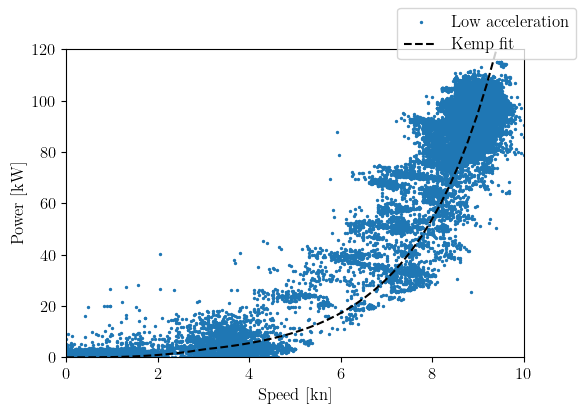

In [8]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit",
    color="black",
    linestyle="--",
)
fig.legend()

1.1102218605243943 1.110843416763416 1.1114649730024375


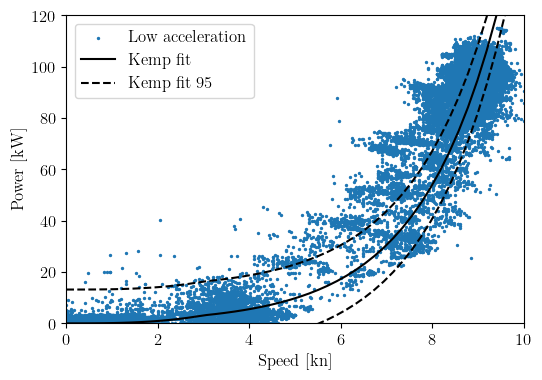

In [9]:
beta = popt[0]
level = 0.95
alpha = 1 - level
se = np.sqrt(pcov[0, 0])
n = len(low_acceleration_speed_and_power[:, 0])
beta_u = beta + stats.t.ppf(alpha / 2.0, n - 1) * se
beta_l = beta + stats.t.ppf(1 - alpha / 2.0, n - 1) * se
print(beta_u / 3.6e-3, beta / 3.6e-3, beta_l / 3.6e-3)

GS = (
    np.power(
        calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta), 2
    )
    * 0.57
    * 0.57
    * pcov[0, 0]
)

beta_u_delta = beta + stats.t.ppf(alpha / 2.0, n - 1) * np.sqrt(GS)
beta_l_delta = beta + stats.t.ppf(1 - alpha / 2.0, n - 1) * np.sqrt(GS)
residual_variance = np.sum(
    np.power(
        low_acceleration_speed_and_power[:, 1]
        - calculate_propulsion_power(
            speeds=low_acceleration_speed_and_power[:, 0],
            length=LENGTH,
            beam=BEAM,
            c4=beta,
        ),
        2,
    )
) / (n - 2)
delta_y = np.sqrt(GS + residual_variance) * stats.t.ppf(1 - alpha / 2.0, n - 1)

fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit",
    color="black",
    linestyle="-",
)
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta)
    + delta_y,
    label="Kemp fit 95% prediction",
    color="black",
    linestyle="--",
)
ax.plot(
    speeds,
    calculate_propulsion_power(speeds=speeds, length=LENGTH, beam=BEAM, c4=beta)
    - delta_y,
    color="black",
    linestyle="--",
)
ax.legend()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


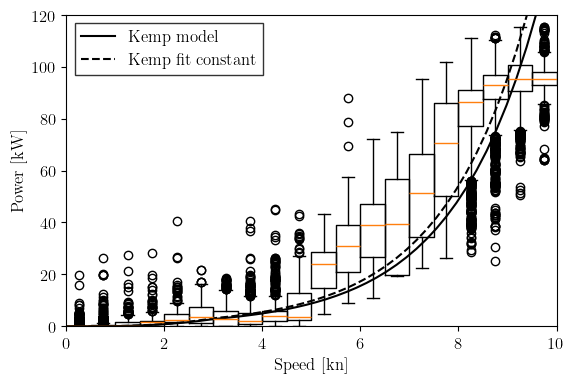

In [10]:
bin_size = 0.5
bins = np.arange(0, 10.1, bin_size)
bins_data = list()
for i in range(0, len(bins) - 1):
    bins_data.append(
        low_acceleration_speed_and_power[
            np.logical_and(
                low_acceleration_speed_and_power[:, 0] >= bins[i],
                low_acceleration_speed_and_power[:, 0] < bins[i + 1],
            ),
            1,
        ]
    )
fig, ax = plt.subplots(figsize=(5.90666, 4))
# plot_power_data(low_acceleration_speed_and_power, ax, label="Low acceleration")
ax.boxplot(
    bins_data, positions=bins[0:-1] + bin_size / 2, widths=0.5, manage_ticks=False
)
ax.plot(
    speeds,
    propulsion_powers_kemp,
    label="Kemp model",
    color="black",
    linestyle="-",
)
ax.plot(
    speeds,
    propulsion_powers_kemp_fit,
    label="Kemp fit constant",
    color="black",
    linestyle="--",
)
ax.set_ylim([0, 120])
ax.set_xlim([0, 10])
ax.set_ylabel("Power [kW]")
ax.set_xlabel("Speed [kn]")
lgd = ax.legend()
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_linewidth(1.0)
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/boxplot.eps",
    format="eps",
)

### Extract transit
Extract operational modes for the selected date and calculate time fishing

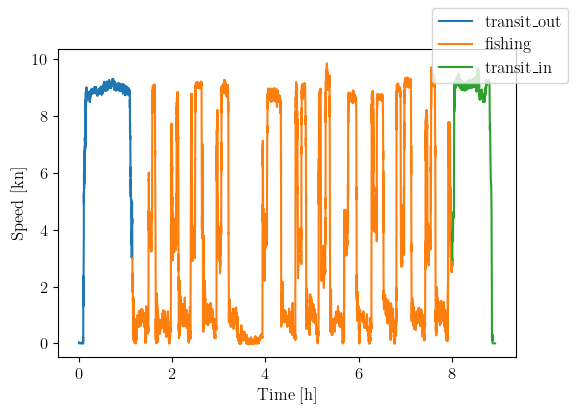

In [11]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
(transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
time_fishing = fishing[-1, 0] - fishing[0, 0]
plot_profiles(ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)
ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")
fig.legend()

### Compare measured and approximated fuel usage for one day

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


Measured consumption: 107.41
Consumption from standard Kemp: 103.02
Consumption from fitted Kemp: 111.89


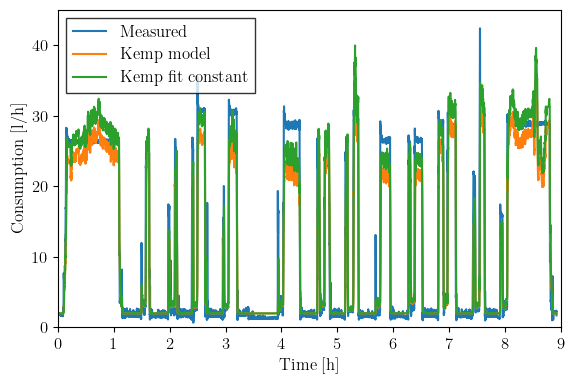

In [12]:
measured_consumption_profile = consumption_profile_from_data(vessel=VESSEL, date=DATE)
measured_consumption = total_consumption_from_profile(measured_consumption_profile)

model_power = calculate_propulsion_power(
    speeds=uniform_filter1d(measured_speed_profile[:, 1], size=10),
    length=LENGTH,
    beam=BEAM,
)
model_power_fit = model_power * power_increase

model_consumption_profile = components_to_profile(
    measured_speed_profile[:, 0],
    calculate_consumption(
        powers=model_power,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

model_consumption_profile_fit = components_to_profile(
    measured_speed_profile[:, 0],
    calculate_consumption(
        powers=model_power_fit,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION,
    ),
)

model_consumption_propulsion = total_consumption_from_profile(model_consumption_profile)
model_consumption_propulsion_fit = total_consumption_from_profile(
    model_consumption_profile_fit
)
power_hydraulics = calculate_hydraulics_energy(hours_fishing=time_fishing)
power_dc = calculate_dc_energy(
    hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
)
hydraulics_consumption = calculate_consumption(
    powers=power_hydraulics,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)
dc_consumption = calculate_consumption(
    powers=power_dc,
    engine_rating=ENGINE_RATING,
    engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
)

fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_profiles(
    ax,
    measured_consumption=measured_consumption_profile,
    model_consumption=model_consumption_profile,
    model_consumption_fit=model_consumption_profile_fit,
)
ax.set_xlim([0, 9])
ax.set_ylim([0, 45])
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_xlabel("Time [h]")
ax.set_ylabel("Consumption [l/h]")
lgd = ax.legend(["Measured", "Kemp model", "Kemp fit constant"], loc=2)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_linewidth(1.0)
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/consumption_profiles.eps",
    format="eps",
)
print(
    f"Measured consumption: {measured_consumption:.2f}\nConsumption from standard Kemp: {model_consumption_propulsion + hydraulics_consumption + dc_consumption:.2f}\nConsumption from fitted Kemp: {model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption:.2f}"
)

### Compare measured and approximated fuel usage for all days

In [13]:
data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "fredrika"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("fredrika_consumptions.csv", "w")
output.write(
    "date,measured,propulsion,propulsion_fit,hydraulics,dc,total,total_fit,propulsion_kwh,propulsion_fit_kwh,hydraulics_kwh,dc_kwh,measured_kwh,kwh,kwh_fit\n"
)
output.close()
output = open("fredrika_consumptions.csv", "a")
for file in files:
    DATE = file.name[3:13]
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    measured_consumption_profile = consumption_profile_from_data(
        vessel=VESSEL, date=DATE
    )
    measured_consumption = total_consumption_from_profile(measured_consumption_profile)

    measured_power_profile = components_to_profile(
        measured_consumption_profile[:, 0],
        calculate_power_from_consumption(
            engine_application=EngineApplication.PROPULSION,
            engine_rating=ENGINE_RATING,
            consumptions=measured_consumption_profile[:, 1],
        ),
    )
    measured_total_power = total_consumption_from_profile(measured_power_profile)

    model_power = calculate_propulsion_power(
        speeds=uniform_filter1d(measured_speed_profile[:, 1], size=10),
        length=LENGTH,
        beam=BEAM,
    )

    model_power_fit = model_power * power_increase

    model_power_total = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power)
    )
    model_power_total_fit = total_consumption_from_profile(
        components_to_profile(measured_speed_profile[:, 0], model_power_fit)
    )
    model_consumption_profile = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_profile_fit = components_to_profile(
        measured_speed_profile[:, 0],
        calculate_consumption(
            powers=model_power_fit,
            engine_rating=ENGINE_RATING,
            engine_application=EngineApplication.PROPULSION,
        ),
    )
    model_consumption_propulsion = total_consumption_from_profile(
        model_consumption_profile
    )
    model_consumption_propulsion_fit = total_consumption_from_profile(
        model_consumption_profile_fit
    )
    power_hydraulics = calculate_hydraulics_energy(hours_fishing=time_fishing)
    power_dc = calculate_dc_energy(
        hours_total=measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]
    )
    hydraulics_consumption = calculate_consumption(
        powers=power_hydraulics,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    dc_consumption = calculate_consumption(
        powers=power_dc,
        engine_rating=ENGINE_RATING,
        engine_application=EngineApplication.PROPULSION_ZERO_IDLE,
    )
    output.write(
        f"{DATE},{measured_consumption},{model_consumption_propulsion},{model_consumption_propulsion_fit},{hydraulics_consumption},{dc_consumption},{model_consumption_propulsion + hydraulics_consumption + dc_consumption},{model_consumption_propulsion_fit + hydraulics_consumption + dc_consumption},{model_power_total},{model_power_total_fit},{power_hydraulics},{power_dc},{measured_total_power},{(model_power_total + power_dc + power_hydraulics)},{(model_power_total_fit + power_dc + power_hydraulics)}\n"
    )

output.close()

### Other speed profiles
Use of theoretical speed profiles to evaluate when speed reduction is benificial

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


Time going out: 1.15 h
Time fishing: 6.86 h
Time going in: 0.92 h
Time total: 8.93 h


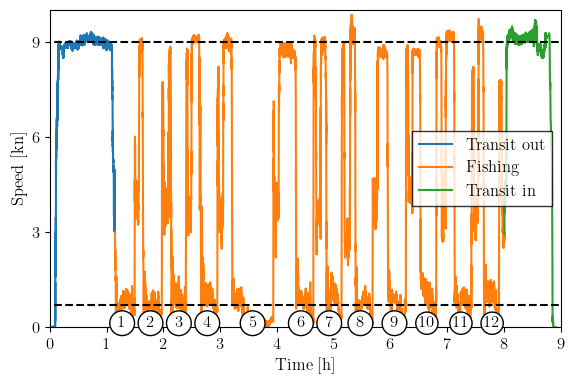

In [14]:
REPRESENTATIVE_DATE = "2023-11-07"

fig, ax = plt.subplots(figsize=(5.90666, 4))

representative_profile = speed_profile_from_data(
    vessel=VESSEL, date=REPRESENTATIVE_DATE
)
representative_consumption_profile = consumption_profile_from_data(
    vessel=VESSEL, date=REPRESENTATIVE_DATE
)

representative_power_profile = components_to_profile(
    representative_consumption_profile[:, 0],
    calculate_power_from_consumption(
        engine_application=EngineApplication.PROPULSION,
        engine_rating=ENGINE_RATING,
        consumptions=representative_consumption_profile[:, 1],
    ),
)

(transit_out, fishing, transit_in) = extract_transit_speed(representative_profile)
plot_profiles(ax=ax, transit_out=transit_out, fishing=fishing, transit_in=transit_in)
xpos = [1.2, 1.7, 2.2, 2.7, 3.5, 4.35, 4.85, 5.4, 6.0, 6.5, 7.1, 7.65]
annotations = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]
pad = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.18, 0.18, 0.18]


for xi, text, padi in zip(xpos, annotations, pad):

    ax.text(xi, 0, text, bbox=dict(boxstyle="circle", fc="white", pad=padi))


ax.plot([-1, 10], [9, 9], linestyle="--", color="black")
ax.plot([-1, 10], [0.7, 0.7], linestyle="--", color="black")
ax.set_xlim([0, 9])
ax.set_ylim([0, 10])
ax.set_yticks([0, 3, 6, 9])
ax.set_xlabel("Time [h]")
ax.set_ylabel("Speed [kn]")

fig.tight_layout()
lgd = ax.legend(
    ["Transit out", "Fishing", "Transit in"],
    loc=7,
    frameon=True,
    facecolor="white",
)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.savefig(
    "figures/example_day.eps",
    format="eps",
)

time_transit_out = transit_out[-1, 0] - transit_out[0, 0]
time_fishing = fishing[-1, 0] - fishing[0, 0]
time_transit_in = transit_in[-1, 0] - transit_in[0, 0]
time_total = representative_profile[-1, 0] - representative_profile[0, 0]
print(
    f"Time going out: {time_transit_out:0.2f} h\nTime fishing: {time_fishing:0.2f} h\nTime going in: {time_transit_in:0.2f} h\nTime total: {time_total:0.2f} h"
)

Note that we have 12 strings of pots and a transit speed of 9 kn both going in/out and between pots. The speed when picking pots is 0.7 kn.

In [15]:
low_speed_fishing = fishing[fishing[:, 1] < 2.5, :]
intervals = np.diff(low_speed_fishing[:, 0])
time_picking_pots = sum(intervals[intervals < 0.1])
print(
    f"Average time per string of pots: {time_picking_pots / 12:.2f} h or {time_picking_pots / 12 * 60:.0f} min."
)
time_fishing_transit = time_fishing - time_picking_pots
print(f"Average time between strings: {time_fishing_transit/11:.2f} h")
len(intervals) - len(intervals[intervals < 0.1])

Average time per string of pots: 0.36 h or 22 min.
Average time between strings: 0.23 h


11

In [16]:
distance_out = distance_from_profile(transit_out)
distance_fishing = distance_from_profile(fishing)
distance_in = distance_from_profile(transit_in)
distance_total = distance_from_profile(representative_profile)
print(
    f"Distance out: {distance_out:0.2f} nm\nDistance fishing: {distance_fishing:0.2f} nm\nDistance in: {distance_in:0.2f} nm\nDistance total: {distance_total:0.2f} nm"
)

Distance out: 9.05 nm
Distance fishing: 22.63 nm
Distance in: 7.35 nm
Distance total: 39.03 nm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


Standard Kemp: 311.65 kWh, 140.53 kWh
Fitted Kemp: 346.19 kWh, 156.10 kWh
Measured: 329.89
Measured: 8.93 h, Simplified: 8.85 h, Simplified low speed: 9.90 h
Standard Kemp: 103.86 l, 58.52 l
Fitted Kemp: 113.43 l, 62.83 l
Measured: 107.41
From models, Standard Kemp: 103.02 l, Fitted Kemp: 111,89 l


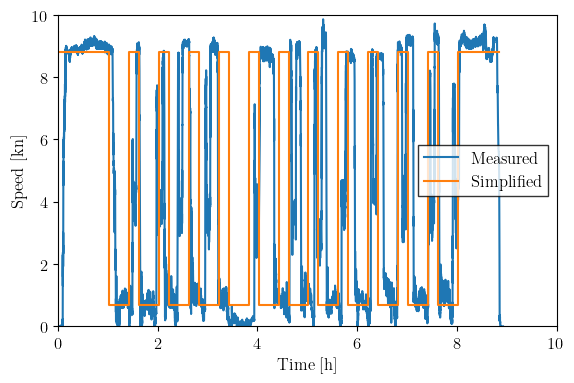

In [17]:
replica = custom_speed_profile(
    distance_out=distance_out,
    speed_out=8.8,
    distance_fishing=distance_fishing,
    speed_fishing=8.8,
    distance_in=distance_in,
    speed_in=8.8,
    time_per_pot=0.4,
)
# replica = custom_speed_profile(
#    distance_out=distance_out,
#    speed_out=9.0,
#    distance_fishing=distance_fishing,
#    speed_fishing=9.0,
#    distance_in=distance_in,
#    speed_in=9.0,
#    time_per_pot=0.4,
# )
lower_speed = custom_speed_profile(
    distance_out=distance_out,
    speed_out=7.0,
    distance_fishing=distance_fishing,
    speed_fishing=7.0,
    distance_in=distance_in,
    speed_in=7.0,
    time_per_pot=0.4,
)

fig, ax = plt.subplots(figsize=(5.90666, 4))
plot_speed_profile(representative_profile, ax)
plot_speed_profile(replica, ax)
# plot_speed_profile(lower_speed, ax)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
fig.tight_layout()
lgd = ax.legend(
    ["Measured", "Simplified"],
    loc=7,
    frameon=True,
    facecolor="white",
)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.savefig(
    "figures/speed_profile_replica.eps",
    format="eps",
)

repilica_power = components_to_profile(
    replica[:, 0],
    calculate_propulsion_power(speeds=replica[:, 1], length=LENGTH, beam=BEAM),
)
lower_speed_power = components_to_profile(
    lower_speed[:, 0],
    calculate_propulsion_power(speeds=lower_speed[:, 1], length=LENGTH, beam=BEAM),
)

repilica_power_fit = components_to_profile(
    replica[:, 0],
    calculate_propulsion_power(speeds=replica[:, 1], length=LENGTH, beam=BEAM)
    * power_increase,
)
lower_speed_power_fit = components_to_profile(
    lower_speed[:, 0],
    calculate_propulsion_power(speeds=lower_speed[:, 1], length=LENGTH, beam=BEAM)
    * power_increase,
)

print(
    f"Standard Kemp: {total_consumption_from_profile(repilica_power):.2f} kWh, {total_consumption_from_profile(lower_speed_power):.2f} kWh"
)
print(
    f"Fitted Kemp: {total_consumption_from_profile(repilica_power_fit):.2f} kWh, {total_consumption_from_profile(lower_speed_power_fit):.2f} kWh"
)
print(f"Measured: {total_consumption_from_profile(representative_power_profile):.2f}")
print(
    f"Measured: {time_total:.2f} h, Simplified: {repilica_power[-1, 0] - repilica_power[0,0]:.2f} h, Simplified low speed: {lower_speed_power[-1, 0] - lower_speed_power[0,0]:.2f} h"
)
print(
    f"Standard Kemp: {total_consumption_from_profile(components_to_profile(repilica_power[:, 0], calculate_consumption(powers=repilica_power[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l, {total_consumption_from_profile(components_to_profile(lower_speed_power[:, 0], calculate_consumption(powers=lower_speed_power[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l"
)
print(
    f"Fitted Kemp: {total_consumption_from_profile(components_to_profile(repilica_power_fit[:, 0], calculate_consumption(powers=repilica_power_fit[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l, {total_consumption_from_profile(components_to_profile(lower_speed_power_fit[:, 0], calculate_consumption(powers=lower_speed_power_fit[:, 1], engine_rating=ENGINE_RATING, engine_application=EngineApplication.PROPULSION))):.2f} l"
)
print(
    f"Measured: {total_consumption_from_profile(representative_consumption_profile):.2f}"
)
print(f"From models, Standard Kemp: 103.02 l, Fitted Kemp: 111,89 l")

Battery properties

In [18]:
kw_kg = 0.19
print(170.0 / 0.8)

print(170.0 / 0.8 / kw_kg)

212.5
1118.421052631579


### Map of the representative date with operational modes

In [19]:
df = load_one_day(vessel=VESSEL, date=REPRESENTATIVE_DATE)
coordinates = df.select(["time", "speed", "latitude", "longitude"]).to_numpy()
coordinates[:, 0] = (coordinates[:, 0] - coordinates[0, 0]) / (3600 * 1e6)

transit_out_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_out[0, 0], coordinates[:, 0] <= transit_out[-1, 0]
    ),
    :,
]
transit_in_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= transit_in[0, 0], coordinates[:, 0] <= transit_in[-1, 0]
    ),
    :,
]
fishing_coordinates = coordinates[
    np.logical_and(
        coordinates[:, 0] >= fishing[0, 0], coordinates[:, 0] <= fishing[-1, 0]
    ),
    :,
]
m = folium.Map(
    location=[58.72, 11.05],
    control_scale=True,
    zoom_start=12,
    min_zoom=12,
    tiles="cartodb positron",
)
folium.PolyLine(
    transit_in_coordinates[:, 2:], tooltip="Transit in", color="#2ca02c"
).add_to(m)
folium.PolyLine(
    transit_out_coordinates[:, 2:], tooltip="Transit out", color="#1f77b4"
).add_to(m)
folium.PolyLine(fishing_coordinates[:, 2:], tooltip="Fishing", color="#ff7f0e").add_to(
    m
)


for i in xpos:
    pot = fishing_coordinates[fishing_coordinates[:, 0] > i, :][0][2:]

    folium.CircleMarker(location=pot, radius=6.0, color="black").add_to(m)
print(coordinates[0, 2:])
m

[58.75572    11.17778171]


In [20]:
m = folium.Map(
    location=[58.72, 11.05],
    control_scale=True,
    zoom_start=12,
    min_zoom=12,
    tiles="cartodb positron",
)
import branca.colormap as cm

step = cm.StepColormap(
    ["green", "yellow", "red"],
    vmin=0,
    vmax=10,
    index=[0, 3.0, 7.0, 10],
    caption="step",
)
step.caption = "Speed [kn]"


folium.ColorLine(
    coordinates[:, 2:],
    colors=coordinates[:, 1],
    colormap=step,
    weight=5,
).add_to(m)
m.add_child(step)
m

### Consumption per day garphs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


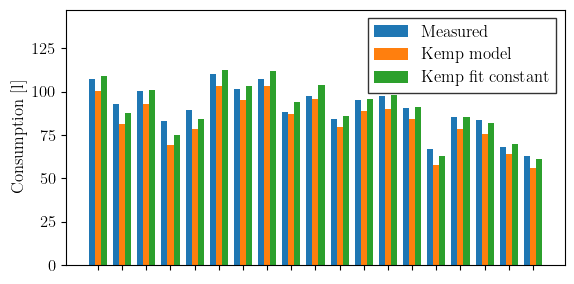

In [21]:
df = pl.read_csv("fredrika_consumptions.csv")
df = df.with_columns(
    (pl.col("measured") - pl.col("total")).alias("residuals"),
    (pl.col("measured") - pl.col("total_fit")).alias("residuals_fit"),
)
residuals = df.select(pl.col("residuals")).to_numpy()
residuals_fit = df.select(pl.col("residuals_fit")).to_numpy()

fig, ax = plt.subplots(figsize=(5.90666, 3))
dates = df.select(pl.col("date")).to_numpy()[:, 0]
ind = np.arange(len(dates))
width = 0.25
ax.bar(ind, df.select(pl.col("measured")).to_numpy()[:, 0], width, label="Measured")
ax.bar(
    ind + width, df.select(pl.col("total")).to_numpy()[:, 0], width, label="Kemp model"
)
ax.bar(
    ind + 2 * width,
    df.select(pl.col("total_fit")).to_numpy()[:, 0],
    width,
    label="Kemp fit constant",
)
ax.tick_params(axis="x", labelrotation=90)
ax.set_xticks(ind + width)
ax.set_xticklabels([""] * 19)
ax.set_ylim([0, 147])
ax.set_ylabel("Consumption [l]")
lgd = ax.legend()
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/all_days_total.eps",
    format="eps",
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


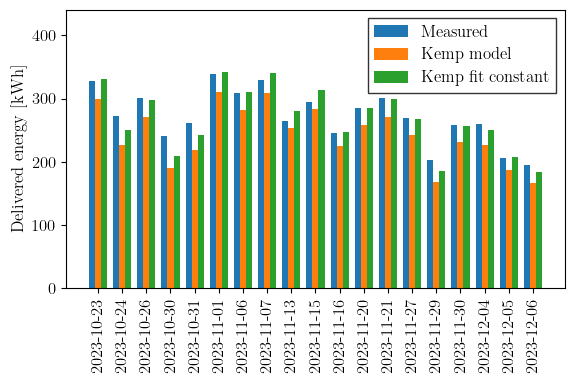

In [22]:
fig, ax = plt.subplots(figsize=(5.90666, 4))
dates = df.select(pl.col("date")).to_numpy()[:, 0]
ind = np.arange(len(dates))
width = 0.25
ax.bar(ind, df.select(pl.col("measured_kwh")).to_numpy()[:, 0], width, label="Measured")
ax.bar(
    ind + width, df.select(pl.col("kwh")).to_numpy()[:, 0], width, label="Kemp model"
)
ax.bar(
    ind + 2 * width,
    df.select(pl.col("kwh_fit")).to_numpy()[:, 0],
    width,
    label="Kemp fit constant",
)
ax.tick_params(axis="x", labelrotation=90)
ax.set_xticks(ind + width)
ax.set_xticklabels(dates)
ax.set_ylim([0, 440])
ax.set_ylabel("Delivered energy [kWh]")
lgd = ax.legend()
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/all_days_total_kwh.eps",
    format="eps",
)

(329.8910821245507, 308.0995997682072, 340.110649226474)
(288.7952247682072, 320.806274226474, 13.725555555555555, 5.578819444444445)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


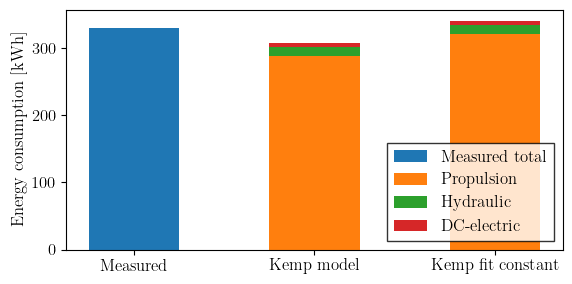

In [23]:
from operator import itemgetter


chosen_data = df.row(by_predicate=pl.col("date") == "2023-11-07", named=True)
totals = itemgetter("measured_kwh", "kwh", "kwh_fit")(chosen_data)
parts = itemgetter("propulsion_kwh", "propulsion_fit_kwh", "hydraulics_kwh", "dc_kwh")(
    chosen_data
)
print(totals)
print(parts)

labels = ("Measured", "Kemp model", "Kemp fit constant")

weight_counts = {
    "Measured": np.array([chosen_data["measured_kwh"], 0, 0]),
    "Propulsion": np.array(
        [0, chosen_data["propulsion_kwh"], chosen_data["propulsion_fit_kwh"]]
    ),
    "Hydraulics": np.array(
        [0, chosen_data["hydraulics_kwh"], chosen_data["hydraulics_kwh"]]
    ),
    "DC": np.array([0, chosen_data["dc_kwh"], chosen_data["dc_kwh"]]),
}
width = 0.5
bottom = np.zeros(3)
fig, ax = plt.subplots(figsize=(5.90666, 3))
for boolean, weight_count in weight_counts.items():
    p = ax.bar(labels, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_ylabel("Energy consumption [kWh]")
lgd = ax.legend(
    ["Measured total", "Propulsion", "Hydraulic", "DC-electric"],
    loc=4,
    frameon=True,
    facecolor="white",
)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()
fig.savefig(
    "figures/kwh_by_load.eps",
    format="eps",
)

In [24]:
residual_mean = np.mean(np.abs(df.select(pl.col("residuals")).to_numpy()[:, 0]))
residual_fit_mean = np.mean(np.abs(df.select(pl.col("residuals_fit")).to_numpy()[:, 0]))
print(residual_mean, residual_fit_mean)

6.953919874007575 2.835577951006011


### Calculating consumption and time for different number of pots and different speeds

In [25]:
data_dir = Path(os.path.abspath("")).resolve() / "py_fish" / "fredrika"
files = [f for f in data_dir.iterdir() if f.is_file()]
output = open("fredrika_operation.csv", "w")
output.write(
    "date,distance_fishing,distance_total,time_fishing,time_total,num_strings\n"
)
output.close()
output = open("fredrika_operation.csv", "a")
strings = [13, 12, 13, 10, 11, 12, 12, 12, 12, 12, 12, 12, 11, 11, 5, 9, 8, 6, 3]
for file, num_strings in zip(files, strings):
    DATE = file.name[3:13]
    measured_speed_profile = speed_profile_from_data(vessel=VESSEL, date=DATE)
    (transit_out, fishing, transit_in) = extract_transit_speed(measured_speed_profile)
    distance_fishing = distance_from_profile(fishing)
    distance_total = distance_from_profile(measured_speed_profile)
    time_fishing = fishing[-1, 0] - fishing[0, 0]
    time_total = measured_speed_profile[-1, 0] - measured_speed_profile[0, 0]

    output.write(
        f"{DATE},{distance_fishing},{distance_total},{time_fishing},{time_total},{num_strings}\n"
    )
output.close()

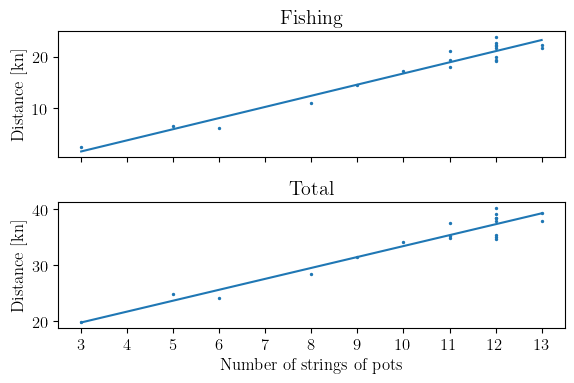

In [26]:
df_op = pl.read_csv("fredrika_operation.csv")
distance_strings = df_op.select(
    pl.col("distance_fishing"), pl.col("distance_total"), pl.col("num_strings")
).to_numpy()

result_fishing = stats.linregress(distance_strings[:, 2], distance_strings[:, 0])
result_total = stats.linregress(distance_strings[:, 2], distance_strings[:, 1])
x = np.arange(3, 14)

fig, (ax1, ax2) = plt.subplots(figsize=(5.90666, 4), nrows=2, sharex=True)
ax1.scatter(distance_strings[:, 2], distance_strings[:, 0], 2)
ax2.scatter(distance_strings[:, 2], distance_strings[:, 1], 2)
ax1.plot(x, result_fishing.slope * x + result_fishing.intercept)
ax2.plot(x, result_total.slope * x + result_total.intercept)
ax1.set_title("Fishing")
ax2.set_xlabel("Number of strings of pots")
ax1.set_xticks(x)
ax1.set_ylabel("Distance [kn]")
ax2.set_ylabel("Distance [kn]")
ax2.set_title("Total")

fig.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


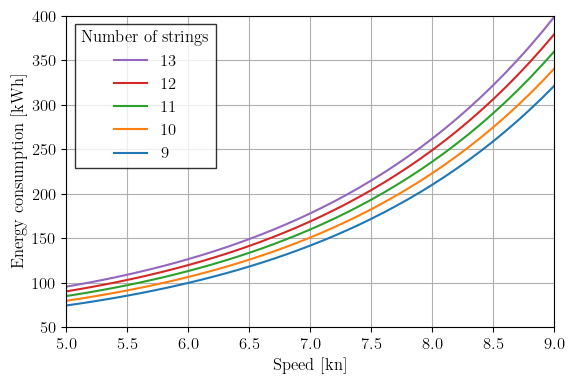

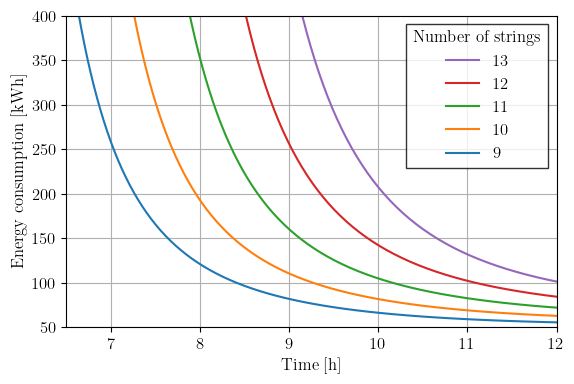

In [27]:
speeds = np.arange(3.0, 11.0, 0.1)
fig, ax = plt.subplots(figsize=(5.90666, 4))
fig2, ax21 = plt.subplots(figsize=(5.90666, 4))
x = np.arange(9, 14)
for pots in x:
    cons = list()
    cons_fit = list()
    time = list()
    for speed in speeds:
        distance_total = result_total.slope * pots + result_total.intercept
        distance_fishing = result_fishing.slope * pots + result_fishing.intercept
        distance_transit = (distance_total - distance_fishing) / 2.0
        simple_speed_profile = custom_speed_profile(
            distance_out=distance_transit,
            speed_out=speed,
            distance_fishing=distance_fishing,
            speed_fishing=speed,
            distance_in=distance_transit,
            speed_in=speed,
            time_per_pot=0.4,
            number_of_pots=pots,
        )
        time_total = simple_speed_profile[-1, 0] - simple_speed_profile[0, 0]
        simple_power_profile = components_to_profile(
            simple_speed_profile[:, 0],
            calculate_propulsion_power(
                speeds=simple_speed_profile[:, 1], length=LENGTH, beam=BEAM
            ),
        )
        simple_power_profile_fit = components_to_profile(
            simple_speed_profile[:, 0],
            calculate_propulsion_power(
                speeds=simple_speed_profile[:, 1], length=LENGTH, beam=BEAM
            )
            * power_increase,
        )

        dc_energy = calculate_dc_energy(hours_total=time_total)
        hydraulics_energy = calculate_hydraulics_energy(
            hours_fishing=time_total - 2 * distance_transit / speed
        )
        cons.append(
            total_consumption_from_profile(simple_power_profile)
            + dc_energy
            + hydraulics_energy
        )
        cons_fit.append(
            total_consumption_from_profile(simple_power_profile_fit)
            + dc_energy
            + hydraulics_energy
        )
        time.append(time_total)
    # ax.plot(speeds, cons)
    ax.plot(speeds, cons_fit, label=f"{pots}")
    ax21.plot(time, cons_fit, label=f"{pots}")


ax.set_xlim([5, 9])
ax.set_ylim([50, 400])
ax.set_xlabel("Speed [kn]")
ax.set_ylabel("Energy consumption [kWh]")
# ax.plot([-1, 10], [347, 347], linestyle="--", color="black")
# ax_time.plot([-1, 10], [8.85, 8.85], linestyle="--", color="black")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(
    reversed(handles), reversed(labels), title="Number of strings", loc="upper left"
)

lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
fig.tight_layout()


handles, labels = ax21.get_legend_handles_labels()
lgd = ax21.legend(
    reversed(handles), reversed(labels), title="Number of strings", loc="upper right"
)
lgd.get_frame().set_edgecolor("k")
lgd.get_frame().set_boxstyle("square", pad=0.0)
ax21.set_xlim([6.5, 12])
ax21.set_ylim([50, 400])
ax21.set_xlabel("Time [h]")
ax21.set_ylabel("Energy consumption [kWh]")
ax21.grid()

fig2.tight_layout()

fig.savefig(
    "figures/energy_speed_pots.eps",
    format="eps",
)

fig2.savefig(
    "figures/energy_time_pots.eps",
    format="eps",
)

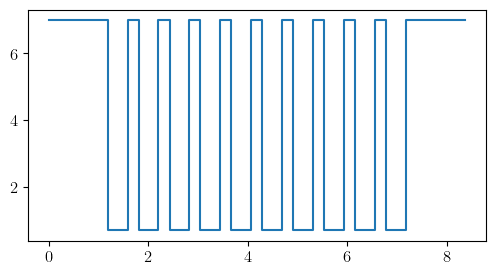

In [28]:
fig, ax = plt.subplots(figsize=(5.90666, 3))

pots = 10
speed = 7
distance_total = result_total.slope * pots + result_total.intercept
distance_fishing = result_fishing.slope * pots + result_fishing.intercept
distance_transit = (distance_total - distance_fishing) / 2.0

simple_speed_profile = custom_speed_profile(
    distance_out=distance_transit,
    speed_out=speed,
    distance_fishing=distance_fishing,
    speed_fishing=speed,
    distance_in=distance_transit,
    speed_in=speed,
    time_per_pot=0.4,
    number_of_pots=pots,
)
plot_profiles(ax, s=simple_speed_profile)